In [1]:
import os
import sys
from os import listdir
from os.path import isfile, join
import IPython.display as ipd
import librosa 
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wav
import numpy as np
from timeit import default_timer as timer

# Implementing CNN with MFCC feature only

In [2]:
filename='E:/Thesis/Dataset/UrbanSound8K/audio/fold3/6988-5-0-4.wav'
ipd.Audio(filename)

In [3]:
def extract_MFCC(file_name):
    audio, sample_rate=librosa.load(file_name, res_type='kaiser_fast')
    mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate , n_mfcc=100).T,axis=0)
    
    return mfccs

In [4]:
start_time=timer()
file_name='E:/Thesis/Dataset/UrbanSound8K/audio/fold3/6988-5-0-4.wav'
a=extract_MFCC(file_name)
end_time=timer()
print('Time to extract MFCC from one file: {:.3f}sec'.format((end_time-start_time)/60))
print(a.shape)

Time to extract MFCC from one file: 0.010sec
(100,)


In [5]:
metadata=pd.read_csv('E:/Thesis/Dataset/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
fold_list = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

In [7]:
stacked_features = []
exceptions=0

start_time = timer()
for i in range(10):
    # get file names
    mypath = 'E:/Thesis/Dataset/UrbanSound8K/audio/'+ fold_list[i] + '/'
    files = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
    
    for fn in files:
        try: # extract features
            mfccs = extract_MFCC(fn)
            features=np.reshape((mfccs),(20,5))
            
        except: # else exception (.ds_store files are part of mac file systems)
            print(fn)
            exceptions += 1
            continue
            
        l_row = metadata.loc[metadata['slice_file_name']==fn.split('/')[-1]].values.tolist()
        label = l_row[0][-1]
        fold = i+1
    
        stacked_features.append([features, features.shape, label, fold])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

C:\Users\User\Anaconda3\lib\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


E:/Thesis/Dataset/UrbanSound8K/audio/fold1/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold2/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold3/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold4/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold5/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold6/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold7/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold8/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold9/.DS_Store
E:/Thesis/Dataset/UrbanSound8K/audio/fold10/.DS_Store
Exceptions:  10
time taken: 11.0 minutes 37.9 seconds
None
Finished feature extraction from all folder


In [8]:
cols=['Stacked_Features', 'Matrix_Shape', 'Label', 'Fold']
Stacked_feature_pd=pd.DataFrame(data=stacked_features , columns=cols)
Stacked_feature_pd.head()

,Stacked_Features,Matrix_Shape,Label,Fold
0,"[[-403.96762, 94.398056, 17.75182, -11.521065,...","(20, 5)",dog_bark,1
1,"[[-368.11002, 128.74481, 28.91274, -21.190063,...","(20, 5)",dog_bark,1
2,"[[-422.47903, 70.38345, 9.934866, 0.0006177825...","(20, 5)",dog_bark,1
3,"[[-260.24, 109.35184, -51.811287, -4.2874146, ...","(20, 5)",dog_bark,1
4,"[[-386.7848, 132.62964, 25.220673, 22.799538, ...","(20, 5)",gun_shot,1


In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


X = np.array(Stacked_feature_pd.Stacked_Features.tolist())
y = np.array(Stacked_feature_pd.Label.tolist())


le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

Using TensorFlow backend.


In [10]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=42)

In [11]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, yy.shape)

(6985, 20, 5) (1747, 20, 5) (6985, 10) (1747, 10) (8732, 10)


In [12]:
x_train=np.reshape(x_train,(x_train.shape[0], 20,5,1))
x_test=np.reshape(x_test,(x_test.shape[0], 20,5,1))
print(x_train.shape, x_test.shape)

(6985, 20, 5, 1) (1747, 20, 5, 1)


In [13]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

In [14]:
model=Sequential()
model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())
#model.add(GlobalAveragePooling2D())


model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(10,activation="softmax"))

In [15]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [16]:
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

1747/1747 [==============================] - 1s 749us/step
Pre-training accuracy: 12.6503%


In [17]:
start_time=timer()
history=model.fit(x_train,y_train,batch_size=50,epochs=30,validation_data=(x_test,y_test))
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Train on 6985 samples, validate on 1747 samples
Epoch 1/30
6985/6985 [==============================] - 9s 1ms/step - loss: 1.9622 - accuracy: 0.3002 - val_loss: 1.3002 - val_accuracy: 0.5615
Epoch 2/30
6985/6985 [==============================] - 8s 1ms/step - loss: 1.3483 - accuracy: 0.5264 - val_loss: 1.1432 - val_accuracy: 0.5976
Epoch 3/30
6985/6985 [==============================] - 8s 1ms/step - loss: 1.0475 - accuracy: 0.6417 - val_loss: 0.7343 - val_accuracy: 0.7602
Epoch 4/30
6985/6985 [==============================] - 10s 1ms/step - loss: 0.8633 - accuracy: 0.7127 - val_loss: 0.7032 - val_accuracy: 0.7813
Epoch 5/30
6985/6985 [==============================] - 9s 1ms/step - loss: 0.7522 - accuracy: 0.7472 - val_loss: 0.5754 - val_accuracy: 0.8025
Epoch 6/30
6985/6985 [==============================] - 9s 1ms/step - loss: 0.6459 - accuracy: 0.7848 - val_loss: 0.5685 - val_accuracy: 0.8191
Epoch 7/30
6985/6985 [==============================] - 10s 1ms/step - loss: 0.5913 - a

In [18]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100)

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100)

Training Accuracy:  98.51109385490417
Testing Accuracy:  90.78420400619507


In [19]:
def print_prediction(file_name):
    a=extract_MFCC(file_name) 
    prediction_feature=np.reshape((a),(20,5))
            
    prediction_feature = prediction_feature.reshape(1, 20, 5, 1)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [20]:
filename= "E:/Thesis/Dataset/UrbanSound8K/audio/fold5/100852-0-0-0.wav"
print_prediction(filename)
ipd.Audio(filename)

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99995160102844238281250000000000
car_horn 		 :  0.00000000201759187135053252859507
children_playing 		 :  0.00000065891805434148409403860569
dog_bark 		 :  0.00000300166993838502094149589539
drilling 		 :  0.00001110309403884457424283027649
engine_idling 		 :  0.00001993432488234248012304306030
gun_shot 		 :  0.00000001413483108336777149816044
jackhammer 		 :  0.00001252403762919129803776741028
siren 		 :  0.00000004814761922489196876995265
street_music 		 :  0.00000111139775071933399885892868


In [21]:
filename= "E:/Thesis/Dataset/UrbanSound8K/audio/fold3/103199-4-0-0.wav"
print_prediction(filename)
ipd.Audio(filename)

The predicted class is: drilling 

air_conditioner 		 :  0.00000000001221210806090500256005
car_horn 		 :  0.00000000720584969471360636816826
children_playing 		 :  0.00000000201624361650942773849238
dog_bark 		 :  0.00000020335538408744469052180648
drilling 		 :  0.99966084957122802734375000000000
engine_idling 		 :  0.00000000216655315909974888199940
gun_shot 		 :  0.00000000012645560987234460981199
jackhammer 		 :  0.00000000292697732717783765110653
siren 		 :  0.00000000000670199139241045571680
street_music 		 :  0.00033895415253937244415283203125


In [22]:
filename= "E:/Thesis/Dataset/UrbanSound8K/audio/fold10/100648-1-0-0.wav"
print_prediction(filename)
ipd.Audio(filename)

The predicted class is: car_horn 

air_conditioner 		 :  0.00000185925614459847565740346909
car_horn 		 :  0.95785307884216308593750000000000
children_playing 		 :  0.00000252309359893843065947294235
dog_bark 		 :  0.00048500907723791897296905517578
drilling 		 :  0.00415701325982809066772460937500
engine_idling 		 :  0.00001294524008699227124452590942
gun_shot 		 :  0.00001146776503446744754910469055
jackhammer 		 :  0.00018228584667667746543884277344
siren 		 :  0.00012882855662610381841659545898
street_music 		 :  0.03716503828763961791992187500000


In [23]:
Class_Label = {'Air_conditioner':0, 'Car_horn':1, 'Children_playing':2, 'Dog_Bark':3, 
               'Drilling':4,'Engine_idling':5, 'Gun_Shot' :6, 'Jackhammer': 7 ,'Siren':8,'Street_Music':9 }

In [24]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = Class_Label.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1747,) (1747,)
                  precision    recall  f1-score   support

 Air_conditioner       0.93      0.96      0.95       195
        Car_horn       0.95      0.99      0.97        73
Children_playing       0.77      0.89      0.83       198
        Dog_Bark       0.93      0.73      0.82       190
        Drilling       0.94      0.92      0.93       222
   Engine_idling       0.95      0.96      0.95       197
        Gun_Shot       0.86      0.74      0.79        57
      Jackhammer       0.95      0.98      0.97       217
           Siren       0.90      0.95      0.92       204
    Street_Music       0.91      0.88      0.89       194

        accuracy                           0.91      1747
       macro avg       0.91      0.90      0.90      1747
    weighted avg       0.91      0.91      0.91      1747



In [25]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred)*100)

90.78420148826561


In [26]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[188   0   1   0   2   1   0   0   0   3]
 [  0  72   0   0   0   0   0   0   0   1]
 [  7   0 177   3   1   2   3   0   3   2]
 [  1   0  22 138   4   3   4   0  15   3]
 [  1   0   3   1 204   3   0   5   0   5]
 [  1   1   4   0   0 190   0   0   0   1]
 [  0   0  10   2   0   0  42   0   2   1]
 [  1   0   0   0   4   0   0 212   0   0]
 [  1   0   6   2   1   1   0   0 193   0]
 [  2   3   8   2   2   1   0   5   1 170]]


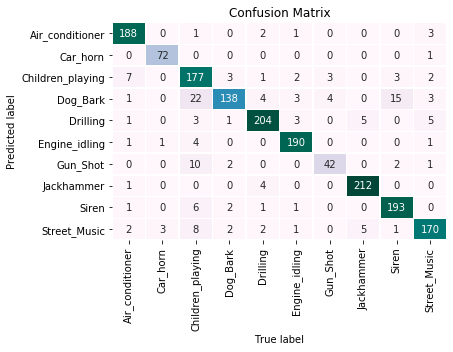

<Figure size 720x288 with 0 Axes>

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax=plt.subplot()
mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,4))
sns.heatmap(mat, square=False, annot=True, fmt='d',cbar=False,linewidths=.5,xticklabels=Class_Label.keys(),yticklabels=Class_Label.keys(), ax=ax, cmap='PuBuGn')
bottom, top= ax.get_ylim()
ax.set_ylim(bottom + 0.5 , top -0.5)
ax.set_title('Confusion Matrix')
ax.set_xlabel('True label')
ax.set_ylabel('Predicted label');

In [28]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

In [29]:
accuracies=acc_per_class(mat)
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

pd.DataFrame({'CLASS':labels, 'ACCURACY': accuracies}).sort_values(by='ACCURACY', ascending=False)


,CLASS,ACCURACY
1,Car Horn,98.630137
7,Jackhammer,97.695853
5,Engine Idling,96.446701
0,Air Conditioner,96.410256
8,Siren,94.607843
4,Drilling,91.891892
2,Children Playing,89.393939
9,Street Music,87.628866
6,Gun Shot,73.684211
3,Dog bark,72.631579


Text(0.5, 1.0, 'Accuracy per Class')

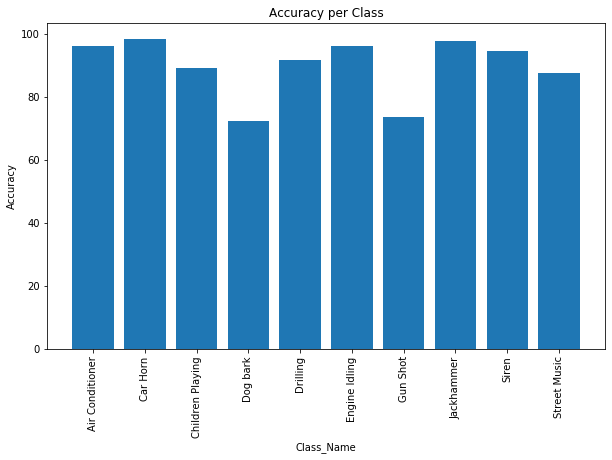

In [30]:
Y=np.around(accuracies , decimals=1)
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]
index=np.arange(len(labels))
plt.figure(figsize=(10,6))
plt.bar(index, Y)
plt.xticks(index, labels, rotation=90)
plt.xlabel('Class_Name')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')